In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def load_json(file_path):
    data = []
    with open(file_path, 'r') as f:
        line = f.readline()
        while line:
            data.append(json.loads(line))
            line = f.readline()
    return pd.DataFrame(data)


def calculate_overall_statistics(df):
    total_time = df['total_time']
    percentiles = np.percentile(total_time, [50, 75, 85, 90, 95, 99])
    
    overall_stats = {
        'avg': total_time.mean(),
        'max': total_time.max(),
        'p50': percentiles[0],
        'p75': percentiles[1],
        'p85': percentiles[2],
        'p90': percentiles[3],
        'p95': percentiles[4],
        'p99': percentiles[5]
    }
    
    return pd.DataFrame([overall_stats])


def calculate_statistics(df):
    bin_size = 5000000
    df = df.copy()
    df.loc[:, 'gas_used_range'] = pd.cut(df['gas_used'], bins=np.arange(0, df['gas_used'].max() + bin_size, bin_size))
    
    grouped = df.groupby('gas_used_range', observed=False)['total_time']

    def under_1_sec_percentage(x):
        return (x < 1).sum() / x.count() * 100

    def under_2_sec_percentage(x):
        return (x < 2).sum() / x.count() * 100

    distribution = grouped.agg(
        avg='mean',
        max='max',
        p50=lambda x: np.percentile(x, 50),
        p75=lambda x: np.percentile(x, 75),
        p85=lambda x: np.percentile(x, 85),
        p90=lambda x: np.percentile(x, 90),
        p95=lambda x: np.percentile(x, 95),
        p99=lambda x: np.percentile(x, 99),
        count='count',
        under_1s_rate=under_1_sec_percentage,
        under_2s_rate=under_2_sec_percentage,
    ).reset_index()

    overall_under_1_sec_percentage = under_1_sec_percentage(df['total_time'])
    overall_under_2_sec_percentage = under_2_sec_percentage(df['total_time'])

    overall_stats = calculate_overall_statistics(df).iloc[0]
    max_gas_used = int((df['gas_used'].max() + bin_size) / bin_size) * bin_size 
    overall_stats['gas_used_range'] = f"(0, {max_gas_used}]"
    overall_stats['count'] = df['total_time'].count()
    overall_stats['under_1s_rate'] = overall_under_1_sec_percentage
    overall_stats['under_2s_rate'] = overall_under_2_sec_percentage

    distribution = pd.concat([distribution, pd.DataFrame([overall_stats])], ignore_index=True)

    return distribution, overall_under_1_sec_percentage, grouped


def plot_histogram(grouped, gas_range):
    total_times = grouped.get_group(gas_range)

    plt.figure(figsize=(10, 6))
    plt.hist(total_times, bins=50, edgecolor='black')
    plt.title(f'Histogram of total_time for gas_used_range {gas_range}')
    plt.xlabel('total_time')
    plt.ylabel('count')
    plt.grid(True)
    plt.show()

In [2]:
df_archive = load_json('base_archive.json')
df_full = load_json('base_full.json')
df_reth = load_json('base_reth.json')

common_blocks = set(df_archive['block_number']).intersection(df_full['block_number']).intersection(df_reth['block_number'])

df_archive = df_archive[df_archive['block_number'].isin(common_blocks)]
df_full = df_full[df_full['block_number'].isin(common_blocks)]
df_reth = df_reth[df_reth['block_number'].isin(common_blocks)]

distribution_archive, under_1_sec_archive, grouped_archive = calculate_statistics(df_archive)
distribution_full, under_1_sec_full, grouped_full = calculate_statistics(df_full)
distribution_reth, under_1_sec_reth, grouped_reth = calculate_statistics(df_reth)

In [3]:
print(f"op-geth archive node | base-mainnet {min(common_blocks)} ~ {max(common_blocks)} | {under_1_sec_archive:.4f}% is under 1s")
distribution_archive

op-geth archive node | base-mainnet 602976 ~ 4545699 | 99.7372% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.019898,6.134,0.015,0.026,0.032,0.037,0.0460,0.11200,3543397,99.991280,99.999351
1,"(5000000, 10000000]",0.145981,7.466,0.072,0.113,0.307,0.406,0.4970,0.80300,111619,99.287756,99.623720
2,"(10000000, 15000000]",0.261148,7.367,0.155,0.277,0.518,0.592,0.7020,1.28004,23588,98.690012,99.317450
3,"(15000000, 20000000]",0.318956,6.835,0.271,0.300,0.324,0.359,0.5290,1.92700,98987,97.140028,99.078667
4,"(20000000, 25000000]",0.341579,7.533,0.261,0.350,0.395,0.435,0.7260,1.71363,79638,96.269369,99.216454
5,"(25000000, 30000000]",0.435120,7.820,0.382,0.437,0.478,0.529,0.6983,2.53600,85495,96.321422,98.450202
6,"(0, 30000000]",0.047921,7.820,0.018,0.031,0.043,0.073,0.2680,0.47800,3942724,99.737238,99.912117


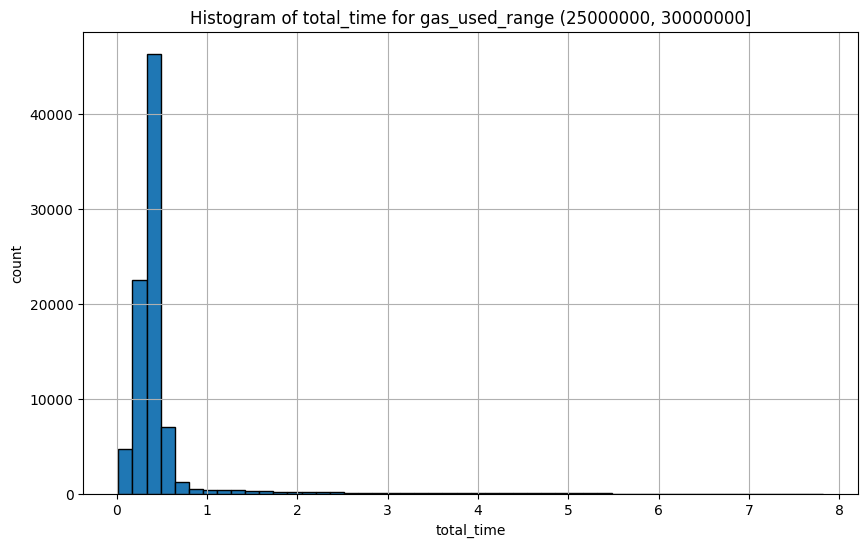

In [4]:
plot_histogram(grouped_archive, distribution_archive.loc[5, 'gas_used_range'])

In [5]:
print(f"op-geth full node | base-mainnet {min(common_blocks)} ~ {max(common_blocks)} | {under_1_sec_full:.4f}% is under 1s")
distribution_full

op-geth full node | base-mainnet 602976 ~ 4545699 | 99.9903% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.018678,0.948,0.016,0.028,0.034,0.039,0.04700,0.06700,3543397,100.000000,100.000000
1,"(5000000, 10000000]",0.099926,2.438,0.072,0.108,0.182,0.231,0.29100,0.41600,111619,99.985666,99.998208
2,"(10000000, 15000000]",0.174754,2.362,0.147,0.213,0.289,0.327,0.42865,0.54500,23588,99.953366,99.995761
3,"(15000000, 20000000]",0.186562,2.734,0.174,0.210,0.228,0.240,0.27800,0.40100,98987,99.938376,99.997980
4,"(20000000, 25000000]",0.231620,3.503,0.220,0.261,0.289,0.309,0.36000,0.74863,79638,99.770210,99.996233
5,"(25000000, 30000000]",0.254926,4.333,0.239,0.300,0.320,0.339,0.38600,0.51700,85495,99.868998,99.998830
6,"(0, 30000000]",0.035551,4.333,0.018,0.033,0.045,0.064,0.18200,0.30400,3942724,99.990286,99.999772


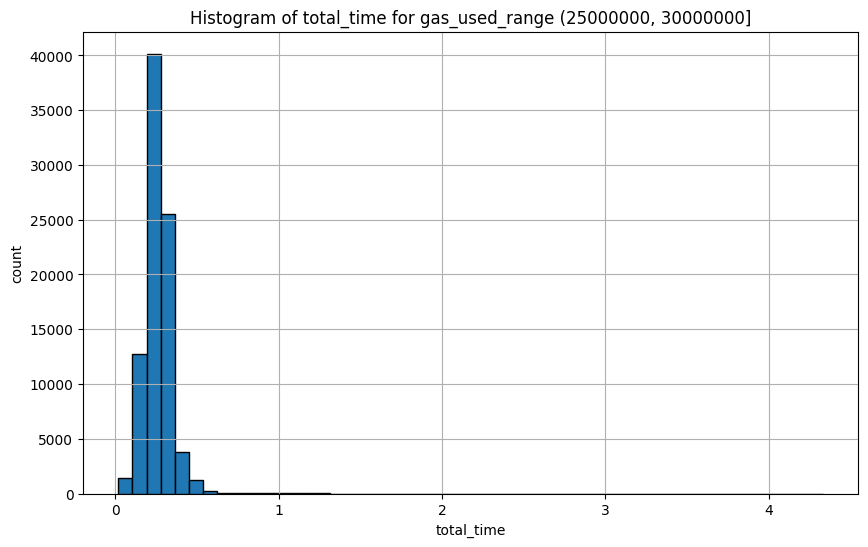

In [6]:
plot_histogram(grouped_full, distribution_full.loc[5, 'gas_used_range'])

In [7]:
print(f"op-reth archive node | base-mainnet {min(common_blocks)} ~ {max(common_blocks)} | {under_1_sec_reth:.4f}% is under 1s")
distribution_reth

op-reth archive node | base-mainnet 602976 ~ 4545699 | 99.3748% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.029202,1.655,0.025,0.045,0.055,0.0630,0.07500,0.10500,3543397,99.999661,100.000000
1,"(5000000, 10000000]",0.172558,4.490,0.087,0.146,0.318,0.4200,0.62100,1.15182,111619,97.864163,99.838737
2,"(10000000, 15000000]",0.301562,5.948,0.178,0.329,0.518,0.6363,0.96800,1.94826,23588,95.345091,99.258097
3,"(15000000, 20000000]",0.409037,8.845,0.354,0.444,0.524,0.6170,0.90700,1.48100,98987,95.996444,99.701981
4,"(20000000, 25000000]",0.435995,7.087,0.327,0.484,0.645,0.7920,1.24115,2.10463,79638,93.283357,98.819659
5,"(25000000, 30000000]",0.627041,13.781,0.486,0.705,0.955,1.1870,1.56200,2.18206,85495,86.145389,98.433827
6,"(0, 30000000]",0.065606,13.781,0.030,0.053,0.070,0.0940,0.32800,0.76300,3942724,99.374772,99.925711


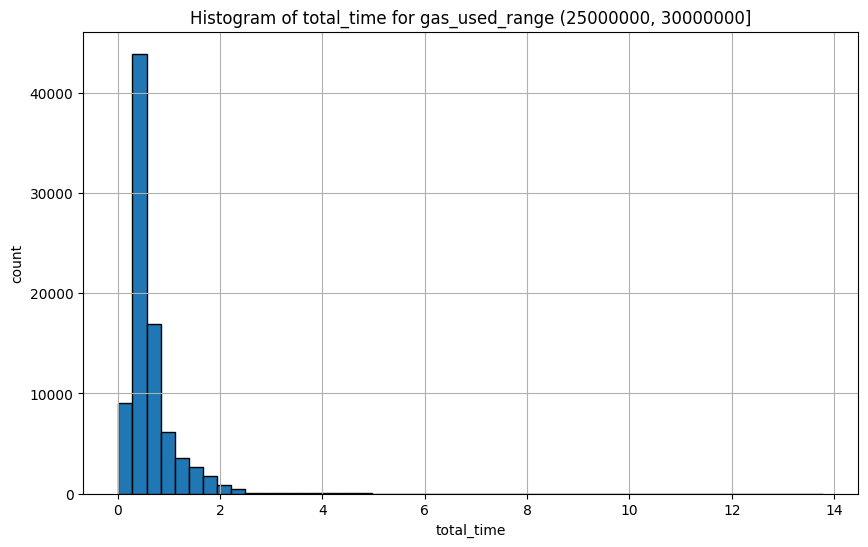

In [8]:
plot_histogram(grouped_reth, distribution_reth.loc[5, 'gas_used_range'])

In [9]:
df_snapshot_archive = load_json('base_snapshot_archive.json')
df_snapshot_full = load_json('base_snapshot_full.json')

distribution_snapshot_archive, under_1_sec_snapshot_archive, grouped_snapshot_archive = calculate_statistics(df_snapshot_archive)
distribution_snapshot_full, under_1_sec_snapshot_full, grouped_snapshot_full = calculate_statistics(df_snapshot_full)

In [10]:
print(f"op-geth archive node | base-mainnet {min(df_snapshot_archive['block_number'])} ~ {max(df_snapshot_archive['block_number'])} | {under_1_sec_snapshot_archive:.4f}% is under 1s")
distribution_snapshot_archive

op-geth archive node | base-mainnet 13686867 ~ 13961397 | 97.9642% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.102943,2.119,0.090,0.103,0.1190,0.1370,0.1650,0.33922,9443,99.173991,99.936461
1,"(5000000, 10000000]",0.175186,3.392,0.152,0.181,0.2073,0.2300,0.2710,0.52462,164539,99.169194,99.835905
2,"(10000000, 15000000]",0.257661,4.878,0.210,0.254,0.2910,0.3240,0.3870,1.60400,69502,98.099335,99.466202
3,"(15000000, 20000000]",0.428000,5.118,0.285,0.358,0.4230,0.5041,1.6131,2.99505,19060,93.226653,96.568730
4,"(20000000, 25000000]",0.560674,5.304,0.371,0.467,0.5630,0.7664,2.0952,3.45444,7397,90.955793,94.335541
5,"(25000000, 30000000]",0.966577,5.210,0.462,0.683,1.8905,3.5480,4.0790,4.71377,4590,81.198257,85.337691
6,"(0, 30000000]",0.234752,5.304,0.174,0.232,0.2780,0.3200,0.4130,1.87670,274531,97.964164,99.128332


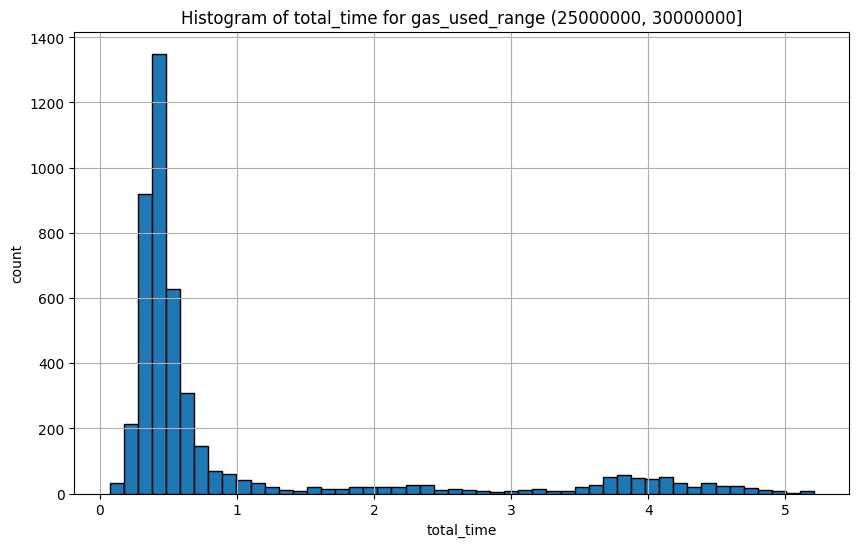

In [11]:
plot_histogram(grouped_snapshot_archive, distribution_snapshot_archive.loc[5, 'gas_used_range'])

In [12]:
print(f"op-geth full node | base-mainnet {min(df_snapshot_full['block_number'])} ~ {max(df_snapshot_full['block_number'])} | {under_1_sec_snapshot_full:.4f}% is under 1s")
distribution_snapshot_full

op-geth full node | base-mainnet 14567037 ~ 14744449 | 99.6455% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.083012,0.624,0.080,0.087,0.092,0.0990,0.13100,0.16900,15186,100.000000,100.000000
1,"(5000000, 10000000]",0.132458,4.430,0.124,0.143,0.154,0.1640,0.19700,0.26900,96567,99.983431,99.996893
2,"(10000000, 15000000]",0.194057,3.763,0.176,0.199,0.216,0.2380,0.28100,0.63400,42807,99.623893,99.971967
3,"(15000000, 20000000]",0.284833,3.095,0.234,0.270,0.312,0.3560,0.62100,1.30060,11941,97.864500,99.857633
4,"(20000000, 25000000]",0.346814,4.730,0.297,0.342,0.388,0.4407,0.73135,1.32187,5514,97.624229,99.891186
5,"(25000000, 30000000]",0.363964,4.066,0.338,0.378,0.416,0.4600,0.55100,1.04515,5398,98.777325,99.944424
6,"(0, 30000000]",0.167051,4.730,0.141,0.185,0.221,0.2550,0.32100,0.64400,177413,99.645460,99.976890


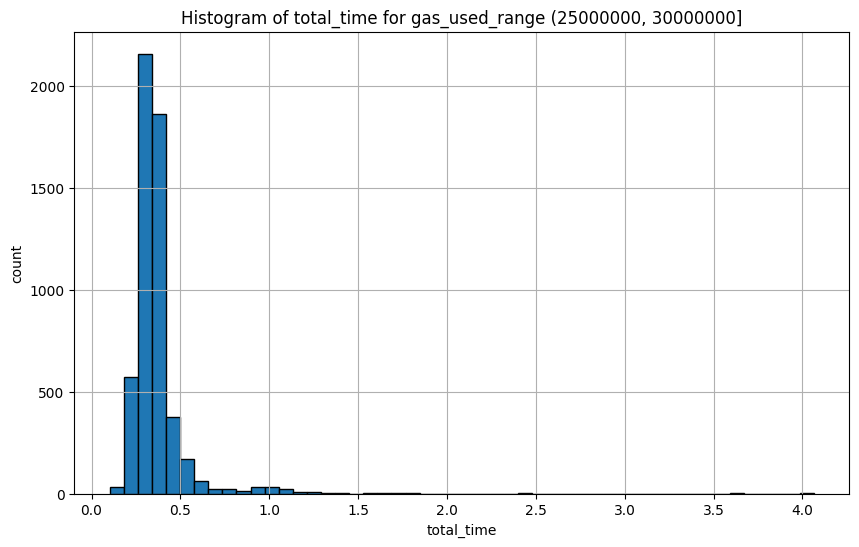

In [13]:
plot_histogram(grouped_snapshot_full, distribution_snapshot_full.loc[5, 'gas_used_range'])